In [1]:
import os
os.chdir("..")

import torch
import torch.nn as nn
import numpy as np
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import MeanAbsolutePercentageError

from data.dataloader import dl_from_numpy, dataloader_info
from models.predictor import GRU
from utils.utils import load_yaml_config

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load configurations
configs = load_yaml_config("configs/stock.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load dataset info
dl_info_train = dataloader_info(configs)
dl_info_test = dataloader_info(configs, train=False)
dataset = dl_info_train['dataset']
seq_length, feature_dim = dataset.window, dataset.feature_dim
batch_size = configs["dataloader"]["batch_size"]
lr = 0.001

# Load data
ori_dl = dl_from_numpy(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"), batch_size=batch_size)
fake_dl = dl_from_numpy(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"), batch_size=batch_size)
dl_test = dl_info_test["dataloader"]

In [3]:
# Model training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=100, description=""):
    model.train()
    with tqdm(range(num_epochs), total=num_epochs) as pbar:
        for e in pbar:
            for data in dataloader:
                x_train = data[:, :seq_length - 1, :].float().to(device)
                y_train = data[:, seq_length - 1, 0].view(-1, 1).float().to(device)

                optimizer.zero_grad()
                outputs = model(x_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
            pbar.set_description(f"{description} loss: {loss.item():.6f}")
    

In [4]:
# Train on synthetic data
model_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_fake = nn.MSELoss()
optimizer_fake = optim.Adam(model_fake.parameters(), lr=lr)
train_model(model_fake, fake_dl, criterion_fake, optimizer_fake, num_epochs=300, description="Synthetic")

Synthetic loss: 0.004732: 100%|██████████| 300/300 [00:28<00:00, 10.62it/s]


In [5]:
# Train on original data
model_ori = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_ori = nn.MSELoss()
optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)
train_model(model_ori, ori_dl, criterion_ori, optimizer_ori, num_epochs=300, description="Original")

Original loss: 0.000968: 100%|██████████| 300/300 [00:28<00:00, 10.57it/s]


In [6]:
# train on original + synthetic data
model_ori_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_ori_fake = nn.MSELoss()
optimizer_ori_fake = optim.Adam(model_ori_fake.parameters(), lr=lr)
train_model(model_ori_fake, fake_dl, criterion_ori_fake, optimizer_ori_fake, num_epochs=300, description="Original")
train_model(model_ori_fake, ori_dl, criterion_ori_fake, optimizer_ori_fake, num_epochs=300, description="Original")

Original loss: 0.000362: 100%|██████████| 300/300 [00:28<00:00, 10.64it/s]


In [16]:
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)

from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(test_data_norm, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [17]:
# Evaluate models on the test dataset
def evaluate_model(model, dataloader):
    model.eval()
    criterion = nn.MSELoss()
    mapeloss = MeanAbsolutePercentageError().to(device)
    total_loss = 0
    predictions, true_vals = [], []
    with torch.no_grad():
        for data, mean, std in dataloader:
            x_test = data[:, :seq_length - 1, :].float().to(device)
            y_test = data[:, seq_length - 1, 0].view(-1, 1).float().to(device)
            mean = mean[:, -1, 0].view(-1, 1).float().to(device)
            std = std[:, - 1, 0].view(-1, 1).float().to(device)
            y_pred = model(x_test)
            total_loss += criterion(y_pred, y_test) * len(data)

            y_test_unnorm = y_test * std + mean
            y_pred_unnorm = y_pred * std + mean

            predictions.append(y_pred_unnorm.cpu().numpy())
            true_vals.append(y_test_unnorm.cpu().numpy())

    total_loss /= len(dataloader.dataset)
    predictions = np.concatenate(predictions)
    true_vals = np.concatenate(true_vals)
    mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()
    
    return total_loss, mape_loss, predictions, true_vals

In [18]:
loss_ori, mape_loss_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)
loss_fake, mape_loss_fake, pred_y_fake, _ = evaluate_model(model_ori_fake, test_loader)

print(f"Test loss on original data: {loss_ori:0.5f}")
print(f"Test MAPE loss on original data: {mape_loss_ori:0.5f}")
print(f"Test loss on synthetic data: {loss_fake:0.5f}")
print(f"Test MAPE loss on synthetic data: {mape_loss_fake:0.5f}")

Test loss on original data: 0.00185
Test MAPE loss on original data: 0.00114
Test loss on synthetic data: 0.00128
Test MAPE loss on synthetic data: 0.00096


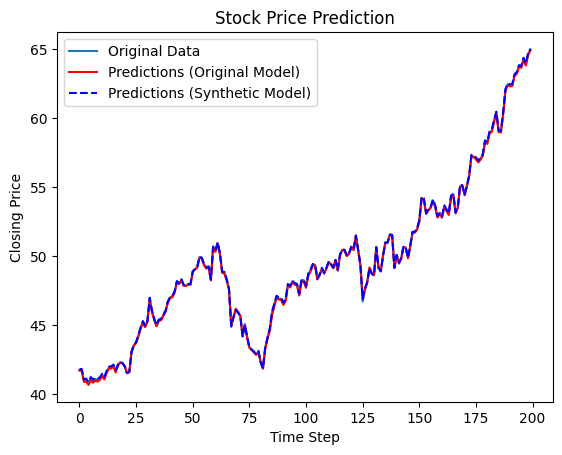

In [19]:
# Visualize predictions
plt.figure()
plt.plot(true_y[:200], label='Original Data')
plt.plot(pred_y_ori[:200], label='Predictions (Original Model)', linestyle='-', color='r')
plt.plot(pred_y_fake[:200], label='Predictions (Synthetic Model)', linestyle='--', color='b')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Closing Price")
plt.show()


In [35]:
import FinanceDataReader as fdr
raw_df = fdr.DataReader('AAPL, MSFT, NVDA, AMZN, COST', "20000101", "20241231")


In [21]:
data = torch.from_numpy(raw_df[-100:].to_numpy()).to(device)
data1 = data[:24,:]
mean = data1.mean(dim=0).to(device)
std = data1.std(dim=0).to(device)
data1_norm = (data1-mean)/std

In [22]:
x = data1_norm[:23, :].view(1,23,-1).float().to(device)
y = data1[23, 0]

In [23]:
print(model_fake(x)*std[0] + mean[0])
print(model_ori(x)*std[0] + mean[0])

tensor([[182.8395]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[183.1777]], device='cuda:0', grad_fn=<AddBackward0>)


In [24]:
y

tensor(183.3960, device='cuda:0', dtype=torch.float64)